# Transformer 

Transformer model implemented in Keras library and trained in Google Colab from scratch on movie review dataset (50 000 samples) to predict whether given review is positive (1) or negative (0). <br>

Its accuracy on test set is over 90% which is near Bidirectional GRU model result (95%). After proper hyperparameters tunning it would reach desired 95%.<br>

However almost 5 million parameters is a bit overkill for such simple task. For instance, GRU model performed slightly better having less than 1 million parameters :V

In [252]:
from keras.layers import Layer, Input, Dense, LayerNormalization, Dropout, \
                         GlobalMaxPooling1D, MultiHeadAttention, Embedding

from keras.layers.experimental.preprocessing import TextVectorization
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from tensorflow.data import Dataset
import tensorflow as tf

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [454]:
# config class used for simplification
class Config:
    
    # transformer module
    vocab_size = 10000
    embedding_dim = 256
    num_heads = 8
    dense_ff = 256
    
    # other params
    dropout = 0.3
    seq_len = 488  # fine tested
    dense_size = 64
    batch_size = 32
    random_state = 2018 # not used
    train_size = 0.7
    val_size = 0.15 # not used
    test_size = 0.15 # not used
    
config = Config()

In [188]:
# read data and convert label column to numeric values
data = pd.read_csv('IMDB Dataset.csv', sep=',', encoding='utf-8')
data['sentiment'] = data['sentiment'].map(lambda x: 1 if x == 'positive' else 0)

In [189]:
# get a glimpse of the dataset
data.sample(3)

,review,sentiment
27638,The movie's premise is spooky: a woman gets pr...,0
13586,"""Stealing Time"" actually dates back to 2001 wh...",0
43388,"Although a ""woman's story,"" I found this still...",1


In [22]:
# vectorizer layer used to tokenize and pad the data
vectorizer = TextVectorization(
    max_tokens=config.vocab_size,
    output_sequence_length=config.seq_len,
    pad_to_max_tokens=True
)

# feed vectorizer with the dataset
vectorizer.adapt(data['review'].tolist())

In [23]:
def create_dataset(df):
    '''
    function used to cast dataframe int proper tensorflow dataset
    
    df:   dataframe
    '''
    X = vectorizer(df['review'].tolist())
    y = df['sentiment'].tolist()
    
    # create tf.dataset
    dataset = Dataset.from_tensor_slices((X, y))
    
    # shuffle and batch for training
    dataset = dataset.shuffle(2018).batch(config.batch_size)
    return dataset

In [24]:
dataset = create_dataset(data)

transformer encoder architecture


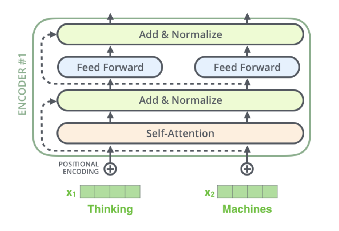

In [63]:
# image of the transformer layer that i attemted to implement
from PIL import Image

print('transformer encoder architecture')
img = Image.open('blueprint.png')
plt.axis('off')
plt.imshow(img);

In [256]:
class Transformer(Layer):
    
    def __init__(self, conf, **kwargs):
        super(Transformer, self).__init__(**kwargs)
        
        # model is a bit overfitting so adding regularization would be a nice idea
        # eg. Dropout between normalizations
        self.num_heads = conf.num_heads
        self.embedding_dim = conf.embedding_dim
        self.dense_ff = conf.dense_ff
        self.layer_norm1 = LayerNormalization()
        self.layer_norm2 = LayerNormalization()
        
        self.attention = MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.embedding_dim
        )
        
        # feed forward neural network after self-attention
        self.ffnn = Sequential(
        [
            Dense(units=self.dense_ff, activation='relu'),
            Dense(units=self.embedding_dim)
        ])
        
        
    
    def call(self, x, training_mode=False):
        # self-attention mechanism
        att = self.attention(x, x)
        
        sum1 = att + x
        norm1 = self.layer_norm1(sum1)
        ffnn1 = self.ffnn(norm1)
        
        sum2 = ffnn1 + norm1
        norm2 = self.layer_norm2(sum2)
        return norm2
    
    
    def get_config(self):
        # overriding get_config() is necessary since I added a few new properties
        config = super().get_config().copy()
        config.update({
            'embedding_dim': self.embedding_dim,
            'num_heads': self.num_heads,
            'dense_ff': self.dense_ff
        })
        return config
    
    
    def __repr__(self):
        # really idk why I added this
        return 'Transformer'

In [257]:
class PositionalEmbeddings(Layer):
    
    def __init__(self, conf, **kwargs):
        super(PositionalEmbeddings, self).__init__(**kwargs)
        
        self.seq_len = conf.seq_len
        self.vocab_size = conf.vocab_size
        self.embedding_dim = conf.embedding_dim
        
        # word embeddings
        self.token_embedding = Embedding(
            input_dim=self.vocab_size,
            output_dim=self.embedding_dim
        )
        
        # position embeddings
        self.position_embedding = Embedding(
            input_dim=self.seq_len,
            output_dim=self.embedding_dim
        )
        

    def call(self, x):
        # positional embedding added to regular embedding
        # in order to add information about position in the sentence
        # since encoder is processing entire sequence at once
        length = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        
        emb_pos = self.position_embedding(positions)
        token_emb = self.token_embedding(x)
        
        embeddings = token_emb + emb_pos
        return embeddings
    
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'vocab_size': self.vocab_size,
            'seq_len': self.seq_len,
            'embedding_dim': self.embedding_dim
        })
        return config
    
    
    def __repr__(self):
        #  ¯\_(ツ)_/¯
        return 'Positional Embeddings'

In [340]:
def create_model(conf):
    '''
    function used to instantiate and connect layers in the model
    
    conf:   Config object with parameters
    '''
    
    embeddings = PositionalEmbeddings(conf)
    transformer = Transformer(conf)
    
    inp = Input(shape=(conf.seq_len,))
    x = embeddings(inp)
    x = transformer(x)
    x = GlobalMaxPooling1D()(x)
    x = Dropout(conf.dropout)(x)
    x = Dense(conf.dense_size, activation='relu')(x)
    out = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inp, outputs=out, name='Transformer_Model')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    
    return model

In [341]:
model = create_model(config)

In [342]:
model.summary()

Model: "Transformer_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 488)]             0         
_________________________________________________________________
positional_embeddings_38 (Po (None, 488, 256)          2684928   
_________________________________________________________________
transformer_48 (Transformer) (None, 488, 256)          2236160   
_________________________________________________________________
global_max_pooling1d_22 (Glo (None, 256)               0         
_________________________________________________________________
dropout_97 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_161 (Dense)            (None, 64)                16448     
_________________________________________________________________
dense_162 (Dense)            (None, 1)           

In [197]:
# splitting dataset into train, validation and test datasets with respect sizes 70%, 15% and 15%
train_data = dataset.take(int(len(dataset)*config.train_size))
rest =  dataset.skip(int(len(dataset)*config.train_size))
test_data = rest.take(int(len(rest)*0.5))
val_data = rest.take(int(len(rest)*0.5))
del rest

In [198]:
# handy callbacks to prevent model from overfitting
callbacks = [
    EarlyStopping(patience=2, monitor='val_loss'),
    ModelCheckpoint(filepath='gdrive/My Drive/Colab/Models/model_{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True)
]

In [249]:
# training process
history = model.fit(
    dataset,
    validation_data=val_data,
    epochs=10,
    callbacks=callbacks,
    shuffle=True
)

In [343]:
# trained model in Google Colab
model.load_weights('models/model.h5')

In [344]:
loss, acc = model.evaluate(val_data)

70/70 [==============================] - 117s 2s/step - loss: 0.1906 - acc: 0.9345


In [345]:
print(f'model test loss:\t{round(loss, 4)}\n'
      f'model accuracy:\t\t{round(acc, 4)}')

model test loss:	0.2159
model accuracy:		0.9196


In [455]:
# sklearn confusion_matrix accepts data in y_true, y_hat format
# I couldn't find any reasonable solution so I created this ugly func
def convert_back_this_stupid_tf_dataset_to_numpy_array(dataset):
    seqs, labels = [], []
    for seq, label in dataset:
        seqs.append(seq.numpy()[0])
        labels.append(label.numpy()[0])
        
    return np.array(seqs), np.array(labels)


X, true = convert_back_this_stupid_tf_dataset_to_numpy_array(dataset)

In [399]:
preds = model.predict(X)

In [404]:
rounded = np.round(preds)
conf_matrix = confusion_matrix(true, rounded)

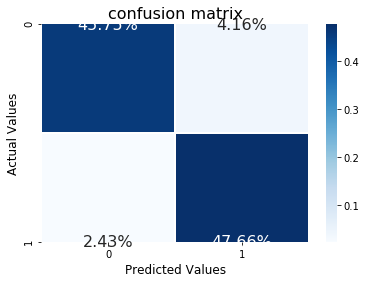

In [449]:
# bugged seaborn annotations
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', 
            cmap='Blues', linewidths=0.25, annot_kws={"size":16})

plt.title('confusion matrix', size=16)
plt.ylabel('Actual Values', size=12)
plt.xlabel('Predicted Values', size=12)
plt.show()

In [430]:
conf_matrix

array([[715,  65],
       [ 38, 745]], dtype=int64)

In [432]:
print(classification_report(true, rounded))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93       780
           1       0.92      0.95      0.94       783

    accuracy                           0.93      1563
   macro avg       0.93      0.93      0.93      1563
weighted avg       0.93      0.93      0.93      1563

